In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import metrics
"""
Name: equalize_data
Input: 
    class1: Data in class1
    class2: Data in class2
Returns: 
    equalized data from training
"""
def equalize_data(class1, class2):
    class1_copy = class1
    class2_copy = class2  
   
    if (class1_copy['y_harmonic'].count() < class2_copy['y_harmonic'].count()):
        while (class1_copy['y_harmonic'].count()<class2_copy['y_harmonic'].count()): 
            temp = [class1_copy, class1]
            class1_copy = pd.concat(temp)
        class1_copy = class1_copy[:class2_copy['y_harmonic'].count()]
    else:
        while (class2_copy['y_harmonic'].count()<class1_copy['y_harmonic'].count()):
            temp = [class2_copy, class2]
            class2_copy = pd.concat(temp)
        class2_copy = class2_copy[:class1_copy['y_harmonic'].count()]
    return (pd.concat([class1_copy, class2_copy]))

def count_errors(predictions):
    count = 0;
    for pred in predictions:
        if (pred[0] != pred[1]):
            count += 1
    return count;

print('functions declared')

functions declared


In [2]:
df_train = pd.read_csv('./Extracted CSVs/RACK_nsynth-valid.csv')
df_test = pd.read_csv('./Extracted CSVs/RACK_rack.csv')

In [3]:
# balance the datasets
input_df_train = equalize_data(df_train[df_train['target'] == 0], df_train[df_train['target'] == 1])
input_df_test = equalize_data(df_test[df_test['target'] == 0], df_test[df_test['target'] == 1])

# randomize datasets
input_df_train = input_df_train.sample(frac=1).reset_index(drop=True)
input_df_test = input_df_test.sample(frac=1).reset_index(drop=True)
# Separate the target and the columns
y_train = input_df_train['target']
x_train = input_df_train.drop(labels=['target'], axis=1)
#Remove the string column
x_train = x_train.drop(x_train.columns[0], axis=1)

# Separate the target and the columns
y_test = input_df_test['target']
x_test = input_df_test.drop(labels=['target'], axis=1)
#Remove the string column
x_test = x_test.drop(x_test.columns[0], axis=1)

data_length_train = len(x_train)
data_length_test = len(x_test)


In [57]:
def simple_decision_tree(max_depth):
    # hyperparameters
    # max_depth of 4 seems to work well for training with validation set

    # create a scikit-learn tree based on validation set
    clf = tree.DecisionTreeClassifier(max_depth=max_depth)
    clf = clf.fit(x_train, y_train)

    # make predictions
    predictions_test = np.vstack((y_test, clf.predict(x_test).tolist())).T
    predictions_train = np.vstack((y_train, clf.predict(x_train).tolist())).T

    num_errors_train = count_errors(predictions_train)
    num_errors_test = count_errors(predictions_test)

    # calculating train and test error to two decimal places
    error_percent_train = round(num_errors_train / data_length_train * 100, 2);
    error_percent_test = round(num_errors_test / data_length_test * 100, 2)

    errorLabels = ('Train Set Error', 'Test Set Error')
    plt.figure(0)
    plt.title("Error in Train vs Test")
    plt.ylabel("Error (%)")
    plt.bar('Train', error_percent_train)
    plt.bar('Test', error_percent_test)

    print('Validation set error percentage: ', error_percent_train)
    print('Test set error percentage: ', error_percent_test)


Validation set error percentage:  0.31
Test set error percentage:  26.85


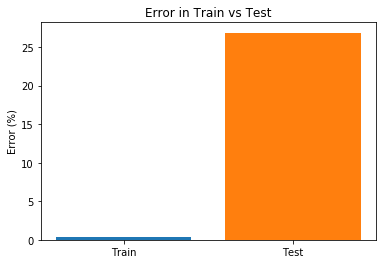

In [58]:
# fit a tree to our data and plot error
simple_decision_tree(1)

In [4]:
# random forest implementation
def random_forest(max_depth):
    # hyperparameters
    # max_depth of 4 or 5 seems to work well for training with validation set

    # create a scikit-learn random forest based on validation set
    clf = RandomForestClassifier(max_depth=max_depth, n_estimators=10)
    clf = clf.fit(x_train, y_train)

    # make predictions
    predictions_test = np.vstack((y_test, clf.predict(x_test).tolist())).T
    predictions_train = np.vstack((y_train, clf.predict(x_train).tolist())).T

    num_errors_train = count_errors(predictions_train)
    num_errors_test = count_errors(predictions_test)

    # calculating train and test error to two decimal places
    error_percent_train = round(num_errors_train / data_length_train * 100, 2);
    error_percent_test = round(num_errors_test / data_length_test * 100, 2)

    errorLabels = ('Train Set Error', 'Test Set Error')
    plt.figure(0)
    plt.title("Error in Train vs Test")
    plt.ylabel("Error (%)")
    plt.bar('Train', error_percent_train)
    plt.bar('Test', error_percent_test)

    print('Validation set error percentage: ', error_percent_train)
    print('Test set error percentage: ', error_percent_test)

Validation set error percentage:  0.12
Test set error percentage:  50.0


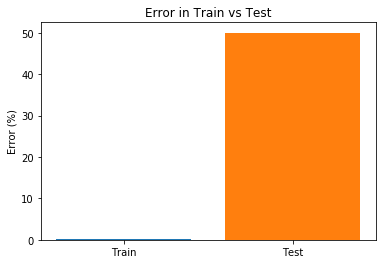

In [7]:
# fit a tree to our data and plot error
random_forest(3)

In [5]:
def ada_boost(estimators):
    classifier = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1),
        n_estimators=estimators
    )
    classifier.fit(x_train, y_train)
    predictions_test = classifier.predict(x_test)
    results_test = confusion_matrix(y_test, predictions_test)
    predictions_train = classifier.predict(x_train)
    results_train = confusion_matrix(y_train, predictions_train)
    num_errors_test = results_test[0][1] + results_test[1][0]
    num_errors_train = results_train[0][1] + results_train[1][0]
    
    # calculating valid and test error to two decimal places
    data_length_test = len(predictions_test)
    data_length_train = len(predictions_train)
    error_percent_train = round(num_errors_train / data_length_train * 100, 2);
    error_percent_test = round(num_errors_test / data_length_test * 100, 2)

    errorLabels = ('Train Set Error', 'Test Set Error')
    plt.figure(0)
    plt.title("Error in Train vs Test")
    plt.ylabel("Error (%)")
    plt.bar('Train', error_percent_train)
    plt.bar('Test', error_percent_test)

    print('Validation set error percentage: ', error_percent_train)
    print('Test set error percentage: ', error_percent_test)

Validation set error percentage:  0.0
Test set error percentage:  26.85


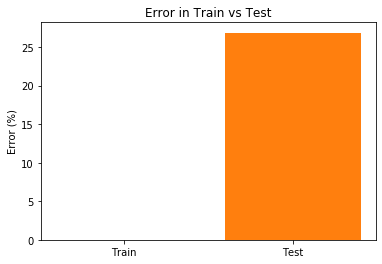

In [6]:
ada_boost(30)

In [8]:
def KNN(k):
    KNN_Classifier = KNeighborsClassifier(n_neighbors = k)
    KNN_Classifier.fit(x_train, y_train)
    
    predictions_train = np.vstack((y_train, KNN_Classifier.predict(x_train).tolist())).T
    length_predictions_train = len(predictions_train)
    num_errors_train = count_errors(predictions_train)
    train_error = round(num_errors_train / length_predictions_train * 100, 2);
    
    predictions_test = np.vstack((y_test, KNN_Classifier.predict(x_test).tolist())).T
    length_predictions_test = len(predictions_test)
    num_errors_test = count_errors(predictions_test)
    test_error = round(num_errors_test / length_predictions_test * 100, 2);
    
    errorLabels = ('Train Set Error', 'Test Set Error')
    plt.figure(0)
    plt.title("Error in Train vs Test")
    plt.ylabel("Error (%)")
    plt.bar('Train', train_error)
    plt.bar('Test', test_error)

    print('Train set error percentage: ', train_error)
    print('Test set error percentage: ', test_error)

Train set error percentage:  6.39
Test set error percentage:  29.63


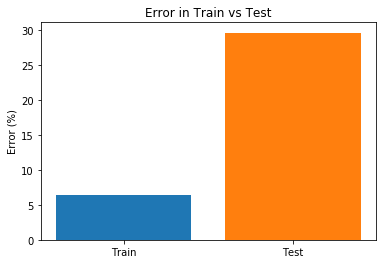

In [20]:
KNN(17)

In [6]:
def runSVM(k, c, g):   
    x_train_svm=x_train
    x_test_svm = x_test

    x_train_svm = x_train_svm.to_numpy()
    x_test_svm = x_test_svm.to_numpy()

    y_train_svm = y_train
    y_train_svm = y_train_svm.values
    
    clf = svm.SVC(kernel=k, C=c, gamma=g)
    clf.fit(x_train, y_train)

    prediction_train = clf.predict(x_train)
    error_train = 100 - 100*metrics.accuracy_score(y_train, prediction_train)
    
    prediction_test = clf.predict(x_test)
    error_test = 100 - 100*metrics.accuracy_score(y_test, prediction_test)

    print("Train set error percentage: ", error_train)
    print("Test set error percentage: ", error_test)
    
    errorLabels = ('Train Set Error', 'Test Set Error')
    plt.figure(0)   
    plt.title("Error in Train and Test")
    plt.ylabel("Error (%)")
    plt.bar('Train', error_train)
    plt.bar('Test', error_test)
    plt.ylim([0, 100])
    plt.show()

Train set error percentage:  0.0
Test set error percentage:  26.851851851851848


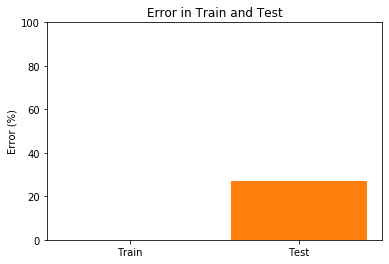

In [7]:
runSVM('rbf', 100, 0.00001)